In [ ]:
!pip install optuna
!pip install keras-tuner --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 10.4 MB/s eta 0:00:00


Trial 60 Complete [00h 00m 27s]
val_loss: 0.0009277714998461306

Best val_loss So Far: 6.660036888206378e-05
Total elapsed time: 00h 26m 29s
===== Best Hyperparameters =====
filters: 96
kernel_size: 2
pool_size: 2
cnn_dropout: 0.1
head_size: 32
num_heads: 3
ff_dim: 96
dense_units: 32
learning_rate: 0.001
Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.7233 - root_mean_squared_error: 0.7580 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0346
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0017 - root_mean_squared_error: 0.0408 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0352
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0014 - root_mean_squared_error: 0.0369 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0409
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0011 - root_mean_squared_error: 0.0330 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0374
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0

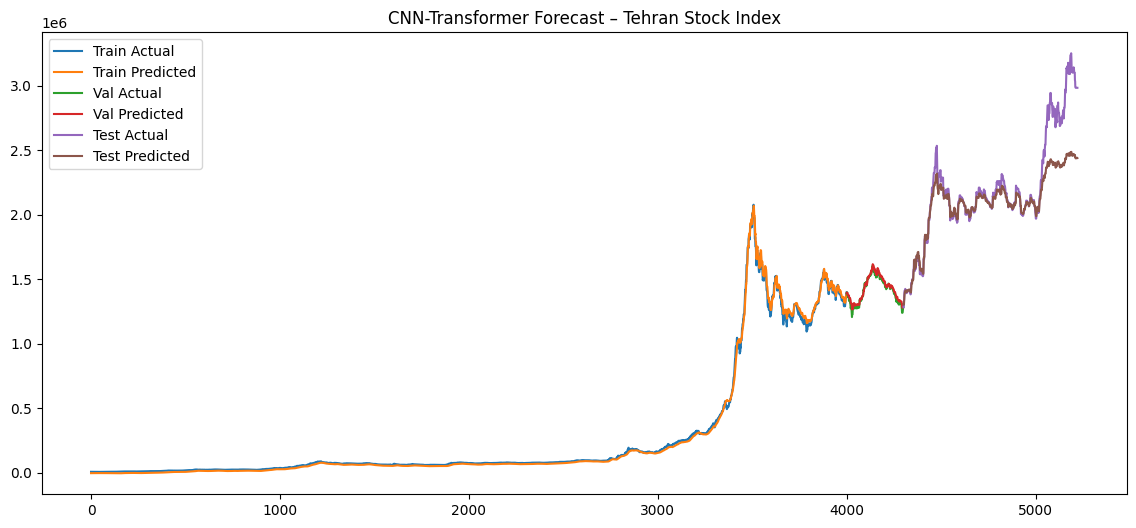

In [ ]:
# --------------------------
# کتابخانه‌ها
# --------------------------
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout,
    Conv1D, MaxPooling1D,
    LayerNormalization, MultiHeadAttention,
    GlobalAveragePooling1D
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import random
import keras_tuner as kt

# --------------------------
# تنظیم seed
# --------------------------
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(seed)

# --------------------------
# خواندن دیتا
# --------------------------
df = pd.read_excel('DATASET.xlsx')
shakhes = df['SHAKHES']
df.index = pd.to_datetime(df['date_m'], format='%Y.%m.%d')

# --------------------------
# ساخت X و y با sliding window
# --------------------------
WINDOW_SIZE = 20

def df_to_X_y(series, window_size=20):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

# --------------------------
# تقسیم داده‌ها
# --------------------------
train_size = 4000
val_size = 300

values = shakhes.values.reshape(-1, 1)
X_all, y_all = df_to_X_y(values, WINDOW_SIZE)

X_all = X_all.reshape(-1, WINDOW_SIZE, 1)
y_all = y_all.reshape(-1, 1)

X_train, y_train = X_all[:train_size], y_all[:train_size]
X_val, y_val     = X_all[train_size:train_size+val_size], y_all[train_size:train_size+val_size]
X_test, y_test   = X_all[train_size+val_size:], y_all[train_size+val_size:]

# --------------------------
# نرمال‌سازی فقط روی train
# --------------------------
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train.reshape(-1,1)).reshape(X_train.shape)

def scale_X(X):
    return scaler.transform(X.reshape(-1,1)).reshape(X.shape)

X_val_scaled  = scale_X(X_val)
X_test_scaled = scale_X(X_test)

y_train_scaled = scaler.transform(y_train)
y_val_scaled   = scaler.transform(y_val)
y_test_scaled  = scaler.transform(y_test)

# --------------------------
# مدل CNN-Transformer برای Keras Tuner
# --------------------------
def build_model(hp):

    inputs = Input(shape=(X_train_scaled.shape[1], 1))

    # -------- CNN --------
    filters = hp.Int('filters', 32, 128, step=32)
    kernel_size = hp.Choice('kernel_size', [2, 3, 5])

    x = Conv1D(filters, kernel_size, padding='same', activation='relu')(inputs)

    pool_size = hp.Choice('pool_size', [2, 3])
    x = MaxPooling1D(pool_size)(x)

    x = Dropout(hp.Float('cnn_dropout', 0.1, 0.5, step=0.1))(x)

    # -------- Transformer Encoder --------
    head_size = hp.Int('head_size', 32, 128, step=32)
    num_heads = hp.Int('num_heads', 2, 4)
    ff_dim    = hp.Int('ff_dim', 32, 128, step=32)

    attn = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(x, x)
    x = LayerNormalization(epsilon=1e-6)(x + attn)

    ff = Dense(ff_dim, activation='relu')(x)
    ff = Dense(x.shape[-1])(ff)
    x = LayerNormalization(epsilon=1e-6)(x + ff)

    # -------- Output --------
    x = GlobalAveragePooling1D()(x)

    dense_units = hp.Int('dense_units', 16, 64, step=16)
    x = Dense(dense_units, activation='relu')(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)

    lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss=MeanSquaredError(),
        metrics=[RootMeanSquaredError()]
    )

    return model

# --------------------------
# Keras Tuner
# --------------------------
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='cnn_transformer_stock'
)

tuner.search(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=20,
    batch_size=32,
    verbose=1
)

# --------------------------
# بهترین هایپرپارامترها
# --------------------------
best_hp = tuner.get_best_hyperparameters(1)[0]

print("===== Best Hyperparameters =====")
for param, value in best_hp.values.items():
    print(f"{param}: {value}")

# --------------------------
# ساخت مدل نهایی
# --------------------------
model = tuner.hypermodel.build(best_hp)

# --------------------------
# Callbacks
# --------------------------
os.makedirs('model1', exist_ok=True)

cp = ModelCheckpoint('model1/best_model.keras', save_best_only=True, monitor='val_loss')
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# --------------------------
# آموزش
# --------------------------
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=50,
    batch_size=32,
    callbacks=[cp, es]
)

# --------------------------
# ارزیابی
# --------------------------
model = tf.keras.models.load_model('model1/best_model.keras')

def predict_and_rescale(X, y):
    yp = scaler.inverse_transform(model.predict(X))
    yt = scaler.inverse_transform(y)
    return yp, yt

train_pred, train_true = predict_and_rescale(X_train_scaled, y_train_scaled)
val_pred, val_true     = predict_and_rescale(X_val_scaled, y_val_scaled)
test_pred, test_true   = predict_and_rescale(X_test_scaled, y_test_scaled)

def metrics(y, p):
    return (
        mean_squared_error(y, p),
        np.sqrt(mean_squared_error(y, p)),
        mean_absolute_error(y, p),
        r2_score(y, p)
    )

print("Train:", metrics(train_true, train_pred))
print("Validation:", metrics(val_true, val_pred))
print("Test:", metrics(test_true, test_pred))

# --------------------------
# نمودار پیش‌بینی
# --------------------------
plt.figure(figsize=(14,6))
plt.plot(train_true, label='Train Actual')
plt.plot(train_pred, label='Train Predicted')

plt.plot(range(len(train_true), len(train_true)+len(val_true)), val_true, label='Val Actual')
plt.plot(range(len(train_true), len(train_true)+len(val_true)), val_pred, label='Val Predicted')

plt.plot(range(len(train_true)+len(val_true),
               len(train_true)+len(val_true)+len(test_true)),
         test_true, label='Test Actual')

plt.plot(range(len(train_true)+len(val_true),
               len(train_true)+len(val_true)+len(test_true)),
         test_pred, label='Test Predicted')

plt.title('CNN-Transformer Forecast – Tehran Stock Index')
plt.legend()
plt.show()


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

# --------------------------
# TimeSeriesSplit
# --------------------------
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

mse_list, rmse_list, mae_list, r2_list = [], [], [], []

print("\n===== TimeSeries Cross Validation =====")

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_all)):
    print(f"\nFold {fold+1}/{n_splits}")

    # --------------------------
    # داده‌های فولد
    # --------------------------
    X_train_fold, X_val_fold = X_all[train_idx], X_all[val_idx]
    y_train_fold, y_val_fold = y_all[train_idx], y_all[val_idx]

    # --------------------------
    # Scaling فقط روی train فولد
    # --------------------------
    scaler_fold = MinMaxScaler()
    X_train_scaled = scaler_fold.fit_transform(X_train_fold.reshape(-1,1)).reshape(X_train_fold.shape)
    X_val_scaled   = scaler_fold.transform(X_val_fold.reshape(-1,1)).reshape(X_val_fold.shape)
    y_train_scaled = scaler_fold.transform(y_train_fold)
    y_val_scaled   = scaler_fold.transform(y_val_fold)

    # --------------------------
    # ساخت مدل با بهترین HP
    # --------------------------
    model_fold = tuner.hypermodel.build(best_hp)

    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # --------------------------
    # آموزش
    # --------------------------
    model_fold.fit(
        X_train_scaled,
        y_train_scaled,
        validation_data=(X_val_scaled, y_val_scaled),
        epochs=50,
        batch_size=32,
        callbacks=[es],
        verbose=0
    )

    # --------------------------
    # پیش‌بینی و inverse scale
    # --------------------------
    y_pred_scaled = model_fold.predict(X_val_scaled)
    y_pred = scaler_fold.inverse_transform(y_pred_scaled)
    y_true = y_val_fold

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)

# --------------------------
# خلاصه نهایی فولدها
# --------------------------
print("\n===== Average metrics over all folds =====")
print(f"MSE : {np.mean(mse_list):.4f} ± {np.std(mse_list):.4f}")
print(f"RMSE: {np.mean(rmse_list):.4f} ± {np.std(rmse_list):.4f}")
print(f"MAE : {np.mean(mae_list):.4f} ± {np.std(mae_list):.4f}")
print(f"R2  : {np.mean(r2_list):.4f} ± {np.std(r2_list):.4f}")



===== TimeSeries Cross Validation =====

Fold 1/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
MSE: 1169265343.5102, RMSE: 34194.5221, MAE: 30748.4410, R2: -3.2414

Fold 2/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
MSE: 1967235.6186, RMSE: 1402.5818, MAE: 914.8840, R2: 0.9738

Fold 3/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
MSE: 114536784916.4001, RMSE: 338432.8366, MAE: 166177.8796, R2: -0.1983

Fold 4/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
MSE: 3140255490.1041, RMSE: 56037.9826, MAE: 41583.2731, R2: 0.8879

Fold 5/5
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
MSE: 44951952997.8513, RMSE: 212018.7562, MAE: 141569.5180, R2: 0.6827

===== Average metrics over all folds =====
MSE : 32760045196.6968 ± 44236814443.8889
RMSE: 128417.3359 ± 127550.1197
MAE : 76198.7991 ± 65270.5192
R2  : -0.1790 ± 1.5867
